# Gini-Based Measures of  Spatial Inequality and Polarization

This notebook explores the measurement of spatial inequality and polarization using the Gini coefficient, with a particular focus on Mexican state-level income data between 1940 and 2000.  `pysal-inequality` extends the classic Gini coefficient, which quantifies income inequality,  to account for spatial relationships among neighboring regions. By leveraging spatial weights matrices, we distinguish between inequality contributions from neighboring areas versus distant areas, enabling a deeper understanding of spatial economic disparities.

The analysis begins with an overview of the data, which includes decennial per capita incomes of Mexican states, followed by the calculation of the classic Gini coefficient to establish baseline inequality levels. We then extend the analysis to the spatial Gini coefficient, incorporating spatial relationships to reveal localized inequality patterns. The notebook culminates in the Gini-based spatial polarization index, which highlights the extent to which the inequality has a spatial structure.

## Imports & Input Data

In [1]:
%load_ext watermark
%watermark

Last updated: 2025-07-06T22:02:42.068646-04:00

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.4.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit



In [2]:
import geopandas
import libpysal
import mapclassify
import numpy
import pandas
import seaborn

import inequality

%watermark -w
%watermark -iv

Watermark: 2.5.0

numpy      : 2.3.1
geopandas  : 1.1.1
mapclassify: 2.9.0
seaborn    : 0.13.2
libpysal   : 4.12.1
pandas     : 2.3.0
inequality : 1.1.2.dev10+g423ae0e.d20250706



To illustrate `pysal-inequality` we utilize a built-in data set on per-capita gross domestic product for the 32 Mexican states measured each decade from 1940 through 2000:

In [3]:
libpysal.examples.explain("mexico")

mexico

Decennial per capita incomes of Mexican states 1940-2000
--------------------------------------------------------

* mexico.csv: attribute data. (n=32, k=13)
* mexico.gal: spatial weights in GAL format.
* mexicojoin.shp: Polygon shapefile. (n=32)

Data used in Rey, S.J. and M.L. Sastre Gutierrez. (2010) "Interregional inequality dynamics in Mexico." Spatial Economic Analysis, 5: 277-298.



In [4]:
pth = libpysal.examples.get_path("mexicojoin.shp")
gdf = geopandas.read_file(pth)

In [5]:
gdf.head()

,POLY_ID,AREA,CODE,NAME,PERIMETER,ACRES,HECTARES,PCGDP1940,PCGDP1950,PCGDP1960,...,GR9000,LPCGDP40,LPCGDP50,LPCGDP60,LPCGDP70,LPCGDP80,LPCGDP90,LPCGDP00,TEST,geometry
0,1,7.252751e+10,MX02,Baja California Norte,2040312.385,1.792187e+07,7252751.376,22361.0,20977.0,17865.0,...,0.05,4.35,4.32,4.25,4.40,4.47,4.43,4.48,1.0,"MULTIPOLYGON (((-113.13972 29.01778, -113.2405..."
1,2,7.225988e+10,MX03,Baja California Sur,2912880.772,1.785573e+07,7225987.769,9573.0,16013.0,16707.0,...,0.00,3.98,4.20,4.22,4.39,4.46,4.41,4.42,2.0,"MULTIPOLYGON (((-111.20612 25.80278, -111.2302..."
2,3,2.731957e+10,MX18,Nayarit,1034770.341,6.750785e+06,2731956.859,4836.0,7515.0,7621.0,...,-0.05,3.68,3.88,3.88,4.04,4.13,4.11,4.06,3.0,"MULTIPOLYGON (((-106.62108 21.56531, -106.6475..."
3,4,7.961008e+10,MX14,Jalisco,2324727.436,1.967200e+07,7961008.285,5309.0,8232.0,9953.0,...,0.03,3.73,3.92,4.00,4.21,4.32,4.30,4.33,4.0,"POLYGON ((-101.5249 21.85664, -101.5883 21.772..."
4,5,5.467030e+09,MX01,Aguascalientes,313895.530,1.350927e+06,546702.985,10384.0,6234.0,8714.0,...,0.13,4.02,3.79,3.94,4.21,4.32,4.32,4.44,5.0,"POLYGON ((-101.8462 22.01176, -101.9653 21.883..."


In [6]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString

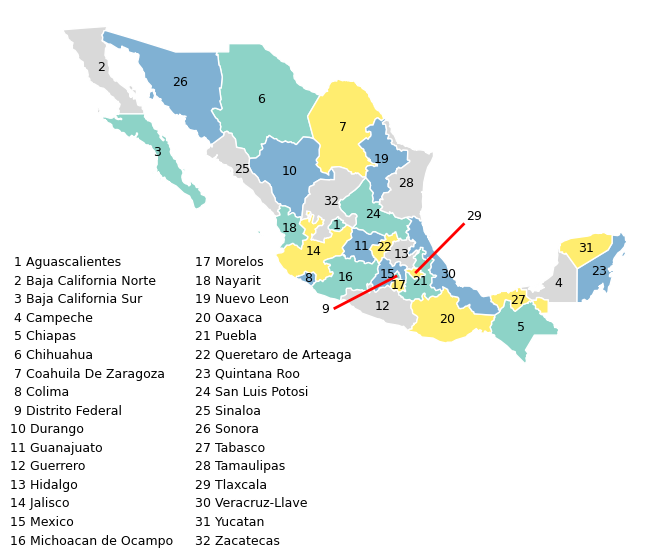

In [7]:
pth = libpysal.examples.get_path("mexicojoin.shp")
gdf = geopandas.read_file(pth)

# we will use greedy from mapclassify
# states to ensure contiguous states are of a different color
sgdf = gdf.sort_values(by="NAME")
sgdf.reset_index(inplace=True)
sgdf["label"] = range(1, 33)
sgdf["greedy"] = mapclassify.greedy(sgdf)

font_size = 9
outside = [9, 29]
oc = [(-103, 17.5), (-95, 22.5)]
oe = [(-102.55, 17.49), (-95.5, 22.1)]
oinfo = zip(outside, oc, strict=True)

sgdf["centroid"] = sgdf.centroid
ax = sgdf.plot(
    figsize=(8, 12),
    column="greedy",
    categorical=True,
    cmap="Set3",
    # legend=True,
    edgecolor="w",
)

table = []
for idx, row in sgdf.iterrows():
    centroid = row["centroid"]
    table.append(f"{idx + 1:2d} {row['NAME']}")
    if idx + 1 not in outside:
        ax.text(
            centroid.x,
            centroid.y,
            str(idx + 1),
            ha="center",
            va="center",
            fontsize=font_size,
            color="black",
        )

for i, out in enumerate(oinfo):
    idx, coords = out
    ax.text(
        coords[0],
        coords[1],
        str(idx),
        ha="center",
        va="center",
        fontsize=font_size,
        color="black",
    )
    start_point = coords
    end_point = sgdf.centroid[idx - 1]

    start_point = oe[i]
    line = LineString([start_point, end_point])

    line_gdf = geopandas.GeoSeries([line])

    line_gdf.plot(ax=ax, color="red", linewidth=2)

for i, label in enumerate(table):
    if i < 16:
        ax.text(
            -120,
            20 - i * 1,
            label,
            ha="left",
            va="center",
            fontsize=font_size,
            color="black",
        )
    else:
        ax.text(
            -110,
            20 - (i - 16) * 1,
            label,
            ha="left",
            va="center",
            fontsize=font_size,
            color="black",
        )
ax.set_axis_off()

We begin with two views of the Mexican state income distribution. On the left we have a choropleth map using
a quintile classification to depict the *spatial distribution* of incomes. 
To the map's right we have a kernel density estimate (KDE) of the *attribute distribution*.

The map and KDE together indicate that economic development was
unevenly distributed across Mexico in 1940, with a majority of states
having relatively low per capita GDP and a small number of outliers
with much higher values.  `pysal-inequality` implements a variety of indices to explore the inequality from distributional and spatial lenses.

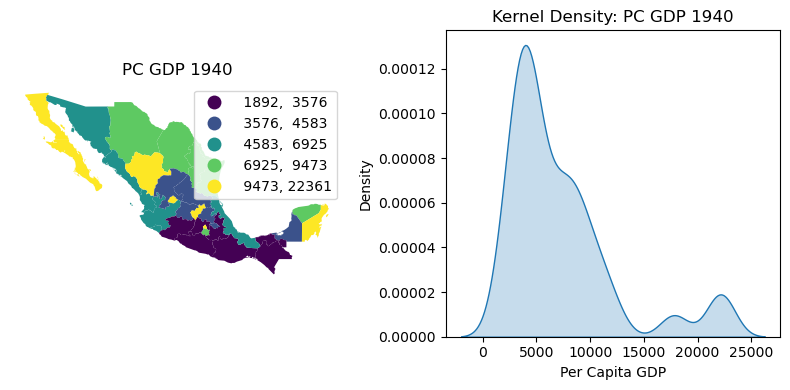

In [8]:
# Two subplots in one row
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Left column: Choropleth map
ax_map = gdf.plot(
    column="PCGDP1940",
    k=5,
    scheme="Quantiles",
    legend=True,
    legend_kwds={"fmt": "{:.0f}"},
    ax=axes[0],
)
ax_map.set_axis_off()
ax_map.set_title("PC GDP 1940")

# Right column: Kernel density plot
seaborn.kdeplot(data=gdf["PCGDP1940"], ax=axes[1], fill=True, bw_adjust=0.5)
axes[1].set_title("Kernel Density: PC GDP 1940")
axes[1].set_xlabel("Per Capita GDP")
axes[1].set_ylabel("Density")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## Classic Gini Coefficient

The Gini coefficient can be expressed as the relative mean absolute difference in incomes between pairs of observations:
$$G = \frac{\sum_i \sum_j \left| x_i - x_j \right |}{2\bar{x}n^2}$$
where $x_i$ is the per capita income of area $i$, $\bar{x}$ is the mean of the area per capita incomes, and $n$ is the number of areas.

The numerator, $\sum_i \sum_j \left | x_i - x_j \right |$ is a measure of inequality in the data set. The Gini normalizes this measure relative to the mean income and the number of pairwise comparisons. As a result of the normalization, the Gini coefficient is bounded between 0 (perfect equality) and 1 (maximum inequality).

Focusing on 1940, the Gini coefficient for Mexican state per capita income is:

In [9]:
gini_1940 = inequality.gini.Gini(gdf["PCGDP1940"].to_numpy())
gini_1940.g

np.float64(0.3537237117345285)

There are a number of possible interpretations of this figure. Using the equation above, the mean relative absolute deviation between all pairs of Mexican states represents 35 percent of the mean income that year.

A second interpretation is a graphical one:

In [10]:
from inequality.schutz import Schutz

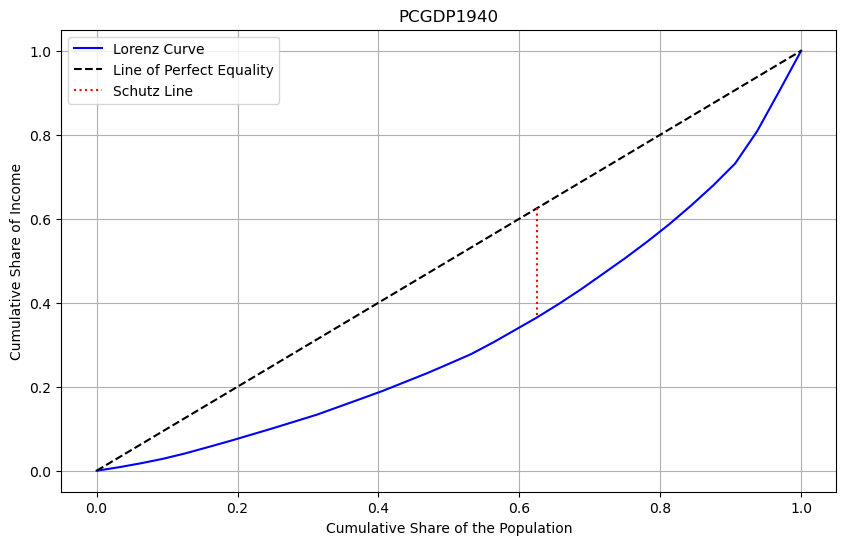

In [11]:
s = Schutz(gdf, "PCGDP1940")
s.plot()

The Gini coefficient of 0.35 represents the percentage of the area below the line of perfect inequality that lies above the Lorenz Curve. 

Thus, as the Gini coefficient increases in value, inequality is increasing, as is the area of the lens formed by the diagonal and the Lorenz curve.

In [12]:
inequality.gini.Gini(gdf["PCGDP2000"].to_numpy()).g

np.float64(0.2581130824882791)

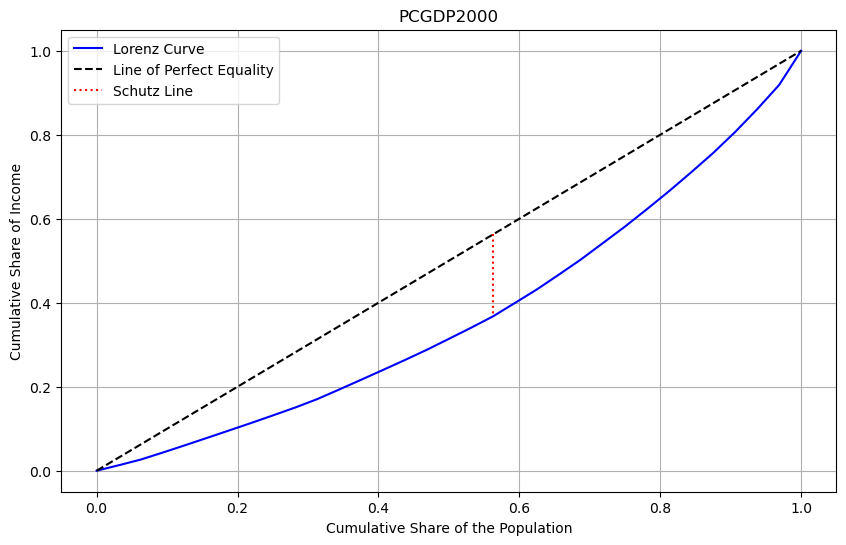

In [13]:
s = Schutz(gdf, "PCGDP2000")
s.plot()

In comparing the distribution from 1940 to that in 2000, we see that overall inequality has declined. The lower value of the Gini for 2000 as well as the smaller area of the inequality lens in the second plot demonstrate the decline.

We can plot the time series of Gini values by decade to see the long term trend of a decline between these two terminal decades, with the steepest drop in inequality occuring in the first two periods of the sample.

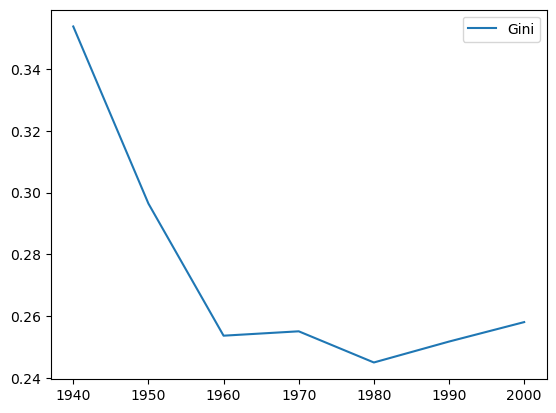

In [14]:
decades = range(1940, 2010, 10)
ginis = [inequality.gini.Gini(gdf[f"PCGDP{decade}"].to_numpy()).g for decade in decades]

ginis_df = pandas.DataFrame(data=ginis, columns=["Gini"], index=list(decades))
ginis_df.plot();

## Spatial Invariance of the Gini Coefficient

The Gini coefficient measures the inequality in the distribution as reflected in the average pairwise difference, normalized to the sample mean.

Although often used to measure inequality in geographical distributions, the geographical configuration of the observations is not actually taken into consideration in the classic Gini. In other words, the Gini coefficient is a *spatially invariant* measure of inequality.
This means that the Gini coefficient is not sensitive to the spatial distribution of the attribute values.

To see this, we can randomly permute the values from the 1940 map and contrast the two spatial distributions. On the left is the choropleth map for the observed 1940 spatial distribution of state income values, and on the right we have the permuted values. Below the two figures are the kernel densities for the attribute distributions associated with each of the maps. The two densities are identical despite the two maps being markedly different.

We also see that the Gini index takes on the same value for each of the spatial distributions.


In [15]:
numpy.random.seed(12345)
gdf["PCGDP1940r"] = numpy.random.permutation(gdf.PCGDP1940)

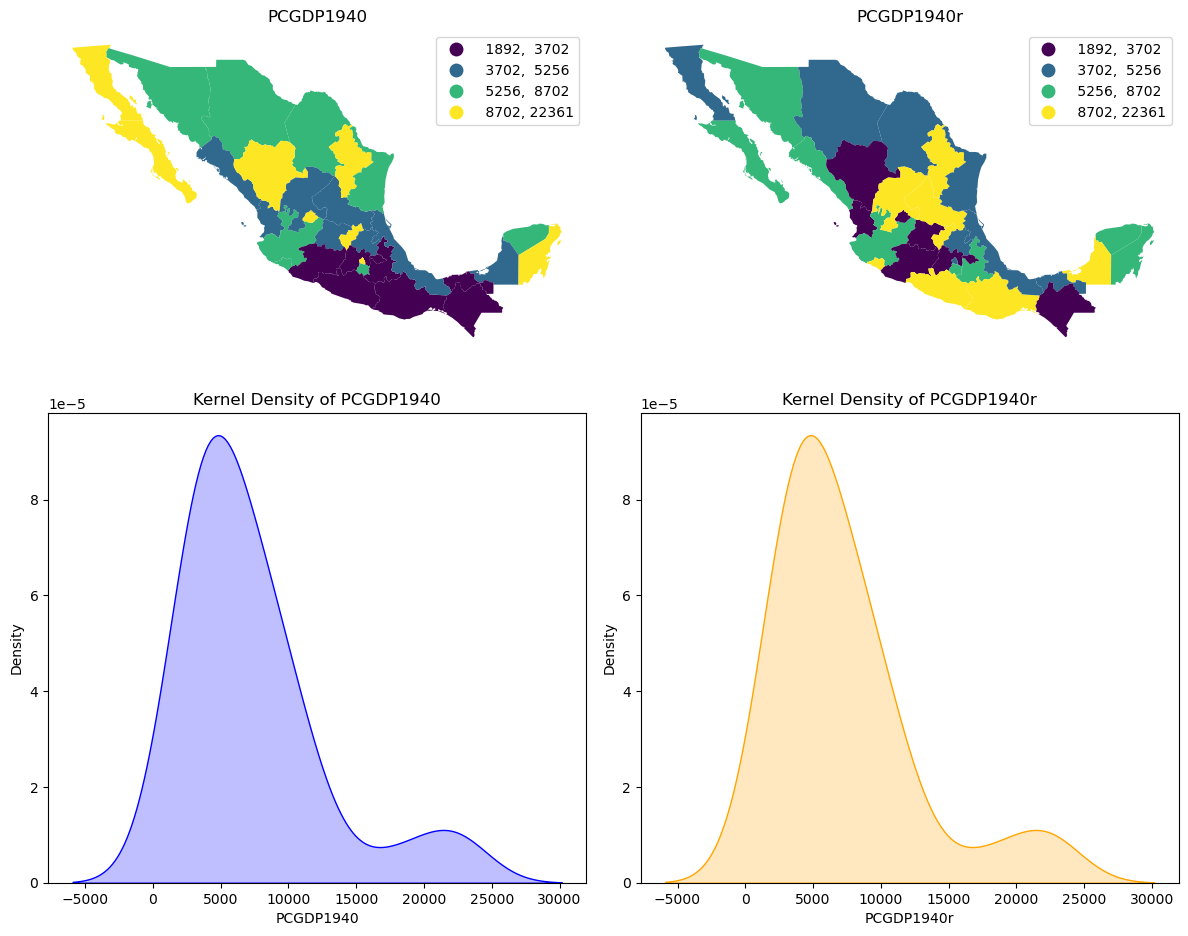

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

gdf.plot(
    column="PCGDP1940",
    ax=axes[0, 0],
    legend=True,
    scheme="quantiles",
    k=4,
    cmap="viridis",
    legend_kwds={"fmt": "{:.0f}"},
)
axes[0, 0].set_title("PCGDP1940")
axes[0, 0].axis("off")

gdf.plot(
    column="PCGDP1940r",
    ax=axes[0, 1],
    legend=True,
    scheme="quantiles",
    k=4,
    cmap="viridis",
    legend_kwds={"fmt": "{:.0f}"},
)
axes[0, 1].set_title("PCGDP1940r")
axes[0, 1].axis("off")

seaborn.kdeplot(gdf["PCGDP1940"], ax=axes[1, 0], fill=True, color="blue")
axes[1, 0].set_title("Kernel Density of PCGDP1940")

seaborn.kdeplot(gdf["PCGDP1940r"], ax=axes[1, 1], fill=True, color="orange")
axes[1, 1].set_title("Kernel Density of PCGDP1940r")

plt.tight_layout()
plt.show()

In [17]:
inequality.gini.Gini(gdf["PCGDP1940"]).g == inequality.gini.Gini(gdf["PCGDP1940r"]).g

/Users/jgaboardi/github_repos/inequality/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)


np.True_

## Spatial Gini Coefficient

To introduce the spatial dimension into the analysis of income inequality, the spatial Gini makes use of a decomposition of the numerator of the Gini:

$$ \sum_i \sum_j \left | x_i - x_j \right | = \sum_i \sum_j  \gamma_{i,j} \left | x_i - x_j \right | +   \sum_i \sum_j(1-\gamma_{i,j}) \left | x_i - x_j \right |$$

where $\gamma_{i,j}$ is a binary indicator taking on a value of 1 if areas $i$ and $j$ are considered spatial neighbors, and 0 otherwise. 
The first term in the decomposition is the contribution to overall inequality due to inequality between pairs of spatial neighbors, while the second term is the contribution due to inequality between pairs of "distant" observations.
In what follows, we note that 
the numerator of the Gini is the sum of the absolute deviations (SAD).

The relative contribution of these two inequality components to the SAD will be a function of two factors:

- the relative number of neighboring (distant) pairs
- the inequality within each set of pairs




`pysal-inequality` originally had a single Gini-based measure of spatial inequality based on the work of Rey and Smith (2013). 
This compared the sum of the observed absolute deviations of the distant pairs against what would be expected were incomes randomly distributed in space. 
Inference on this index relies on random permutations of the observed values to simulate the null hypothesis of spatially random incomes.

To implement the spatial Gini, a definition of neighboring pairs is required. For this, we can use a Queen contiguity rule where two states are considered neighbors if their borders touch:

In [18]:
wq = libpysal.weights.Queen.from_dataframe(gdf, use_index=False)

In [19]:
numpy.random.seed(12345)
gs = inequality.gini.Gini_Spatial(gdf["PCGDP1940"], wq)

The sum of the absolute differences between non-neighbor pairs is stored in the `gc.wcg` attribute:

In [20]:
gs.wcg

np.float64(4735906.0)

Whether this value is large or not, is a question of inference.
A pseudo p-value based on random permutations is stored in the `gs.p_sim` attribute:

In [21]:
gs.p_sim

np.float64(0.01)

The `gs.p_sim` value of 0.01 indicates that none of the 99 random permutations of incomes in space generated a sum of the pairwise differences for the distant pairs that was as large as what we observed in the actual pattern.

Repeating this analysis for the same year, but with the random spatial distribution of the attribute values:

In [22]:
gsr = inequality.gini.Gini_Spatial(gdf["PCGDP1940r"], wq)
gsr.wcg

np.float64(4457788.0)

we see that the differences between the "distant" pairs has declined relative to what we saw for the observed distribution.
Moreover, the spatial gini index for the random distribution is no longer statistically significant:

In [23]:
gsr.p_sim

np.float64(0.29)

## Gini Spatial Polarization Index

Using the decomposition of the SAD into the two components, we can draw inspiration from the spatial polarization literature where Zhang and Kanbur (2001)  have suggested that an index of polarization defined as a ratio of inequality between regions over inequality within regions. Adapting this to our Gini decomposition, one such Gini-Based Spatial Polarization Index could be:
$$
GP = \frac{ \sum_i \sum_j(1-\gamma_{i,j}) \left | x_i - x_j \right |} {\sum_i \sum_j  \gamma_{i,j} \left | x_i - x_j \right | }  $$


However, simply decomposing the SAD into that due to the neighboring pairs and that due to the distant pairs will place more weight on the distant pairs component.
This is because they will generally outnumber the  neighboring pairs.

Thus, a polarization index formed as the ratio of the two components would be difficult to interpret and therefore potentially misleading.
Instead,
the polarization should take the relative size of the two pair sets into account:



$n_{\text{pairs}} = n(n-1)/2$

$n_{\text{pairs}} = n_{\text{neighbor pairs}} + n_{\text{distant pairs}}$

Under the null, the average difference between two observations should be the same, whether the pair of observations are neighbors or not. That means that, under the null:

$E[GP] = \frac{n_{\text{distant pairs}}} {n_{\text{neighbor pairs}}}$

We can use this to normalize and define the Gini Spatial Polarization index as:
$$
GP/E[GP] = \left( \frac{ \sum_i \sum_j(1-\gamma_{i,j}) \left | x_i - x_j \right |} {\sum_i \sum_j  \gamma_{i,j} \left | x_i - x_j \right | } \right ) / \left ( \frac{n_{\text{distant pairs}}} {n_{\text{neighbor pairs}}} \right )
$$

We can view this index in two ways. First, the Gini Polarization is expressed relative to its expected value. In cases where this exceeds 1, the differences due to distant pairs is larger than that due to neighboring pairs under the expectation of no difference.

The second view of the Gini Polarization index is as a ratio of the average pairwise difference for the distant pairs over the average pairwise difference for the neighboring pairs.

In [24]:
from scipy.stats import gaussian_kde

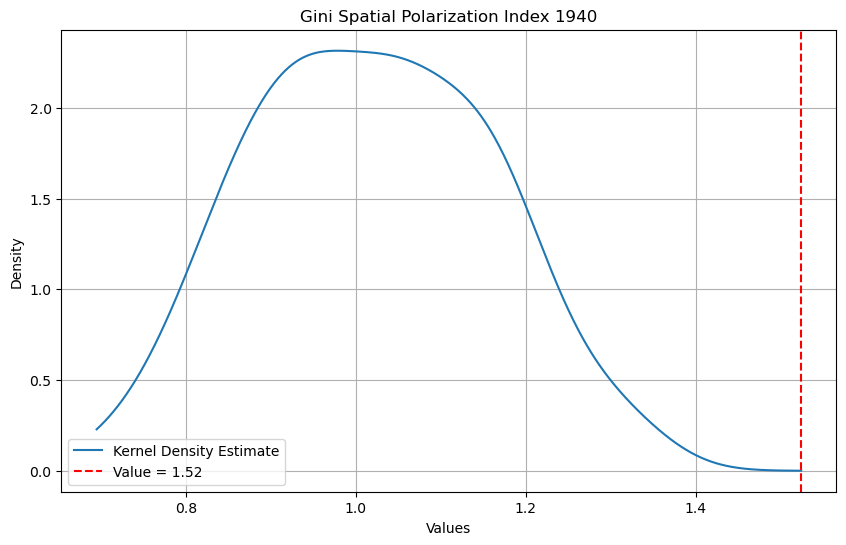

np.float64(0.01)

In [25]:
data = gs.polarization_sim
obs = gs.polarization

kde = gaussian_kde(data)
maxd = max(max(data), obs)
x_range = numpy.linspace(min(data), maxd, 1000)
kde_values = kde(x_range)

plt.figure(figsize=(10, 6))
plt.plot(x_range, kde_values, label="Kernel Density Estimate")
plt.axvline(x=obs, color="red", linestyle="--", label=f"Value = {obs:.2f}")
plt.title("Gini Spatial Polarization Index 1940")
plt.xlabel("Values")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

gs.polarization_p_sim

The Gini Polarization index of 1.52 means that the average pairwise difference between observations that are distant is 52 percent larger than the average pairwise difference for neighboring observations.
The kernel density of the spatial polarization indices from the 99 random permutations of the observed income values for 1940 suggests that the observed index value is significantly different from what would be expected under the null of a spatially random income distribution. In fact, none of the synthetic distributions generated spatial polarization values as large as the observed value.

If we repeat this for the random permutation for 1940 that we used above, the spatial polarization index for the "observed" spatial distribution takes on the value of 0.92.
And, based on the pseudo p-value, this index is not a significant departure from the null of spatially random incomes for 1940.

In [26]:
gsr.polarization

np.float64(0.9232850295559094)

In [27]:
gsr.polarization_sim.mean()

np.float64(1.001666653801155)

In [28]:
gsr.polarization_sim.max()

np.float64(1.343479320163225)

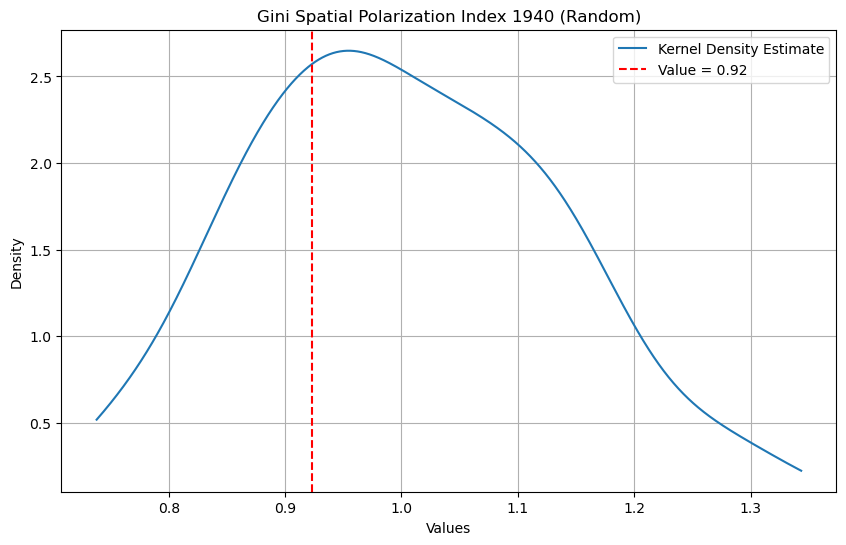

np.float64(0.72)

In [29]:
# Data array
data = gsr.polarization_sim

obs = gsr.polarization

# Kernel Density Estimation
kde = gaussian_kde(data)
maxd = max(max(data), obs)
x_range = numpy.linspace(min(data), maxd, 1000)
kde_values = kde(x_range)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_range, kde_values, label="Kernel Density Estimate")
plt.axvline(x=obs, color="red", linestyle="--", label=f"Value = {obs:.2f}")
plt.title("Gini Spatial Polarization Index 1940 (Random)")

plt.xlabel("Values")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

gsr.polarization_p_sim

### Alternative neighbor definitions
The spatial decomposition used in both the spatial Gini and the Gini
spatial polarization index can accommodate different definitions of
neighboring pairs. To illustrate this, we utilize a regional partition
scheme used by Hanson (1996) to study the effects of the North
American Free Trade Agreement. This assigns the states into five
exhaustive and mutually exclusive regions portrayed below. Using this
partition we can defined neighbor pairs based on regional membership.
That is, two states belonging to the same region constitute a
neighboring pair, while two states belonging to different regions are
defined as a distant pair.

In [30]:
regimes = gdf["HANSON98"]

wb = libpysal.weights.block_weights(regimes, silence_warnings=True)
wb

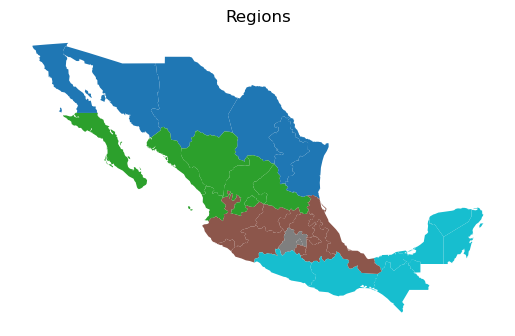

In [31]:
ax = gdf.plot(column="HANSON98", categorical=True)
ax.set_title("Regions")
ax.set_axis_off()

In [32]:
numpy.random.seed(12345)
gsh = inequality.gini.Gini_Spatial(gdf["PCGDP1940"], wb)
gsh.p_sim

np.float64(0.01)

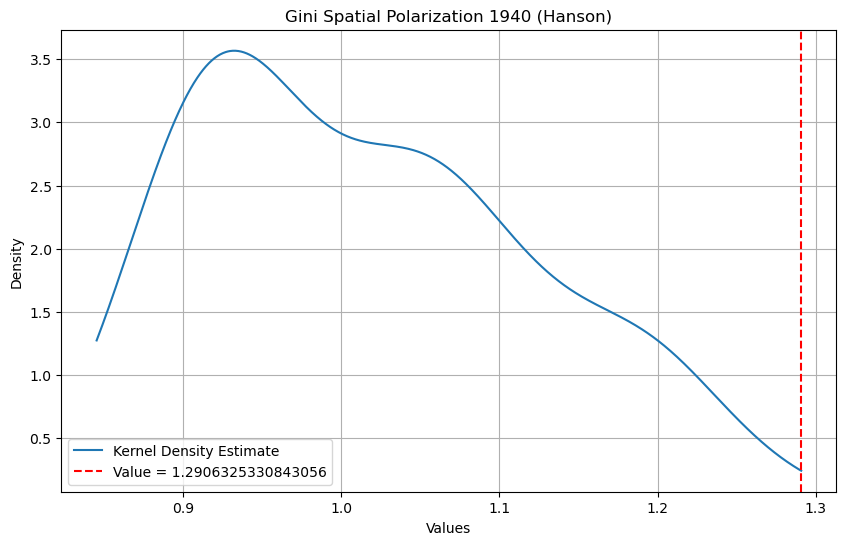

In [33]:
# Data array
data = gsh.polarization_sim

obs = gsh.polarization

# Kernel Density Estimation
kde = gaussian_kde(data)
maxd = max(max(data), obs)
x_range = numpy.linspace(min(data), maxd, 1000)
kde_values = kde(x_range)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_range, kde_values, label="Kernel Density Estimate")
plt.axvline(x=obs, color="red", linestyle="--", label=f"Value = {obs}")
plt.title("Gini Spatial Polarization 1940 (Hanson)")
plt.xlabel("Values")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

The Gini Spatial Polarization index takes on a value of 1.29 for the
Hanson partition, with an associated p-value of 0.01. Note that the
shape of the index distribution under the null is markedly different
from that based on the Queen contiguity structure. In both cases, the
observed index values are significant, however it is clear that the
spatial structure of the particular neighbor graph needs to be taken
into account to ensure meaningful inference.

Finally, we repeat the analysis using the Hanson partition, but this time for the random spatial distribution of incomes in 1940.
As was the case for the Queen definition of neighbors, the polarization index is no longer significant for this synthetic distribution.


In [34]:
# Random Incomes
gshr = inequality.gini.Gini_Spatial(gdf["PCGDP1940r"], wb)
gshr.p_sim

np.float64(0.35)

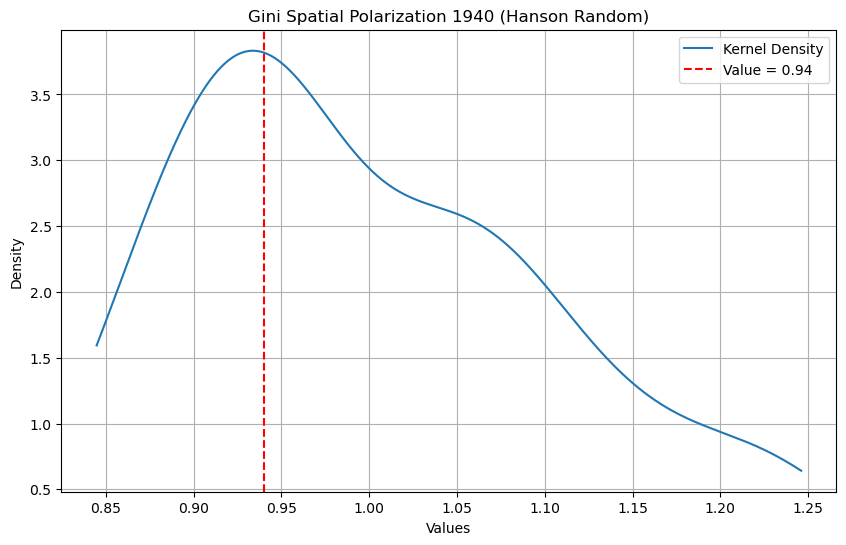

In [35]:
data = gshr.polarization_sim

obs = gshr.polarization

# Kernel Density Estimation
kde = gaussian_kde(data)
maxd = max(max(data), obs)
x_range = numpy.linspace(min(data), maxd, 1000)
kde_values = kde(x_range)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_range, kde_values, label="Kernel Density")
plt.axvline(x=obs, color="red", linestyle="--", label=f"Value = {obs:.2f}")
plt.title("Gini Spatial Polarization 1940 (Hanson Random)")

plt.xlabel("Values")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

## References

- Hanson, Gordon H. U.S.-Mexico Integration and Regional Economies. Cambridge: National Bureau of Economic Research, 1996.
- Rey, Sergio J., and Richard J Smith. “A Spatial Decomposition of the Gini Coefficient.” Letters in Spatial and Resource Sciences 6 (2013): 55–70.
- Zhang, Xiaobo, and Ravi Kanbur. “What Difference Do Polarisation Measures Make?: An Application to China.” Journal of Development Studies 37 (2001): 85–98.